In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

#### Get the recent marketplace data using yahoo finance api

In [10]:
def fetch_stock_data(ticker, start='2010-01-01', end='2024-01-01'):
    df = yf.download(ticker, start=start, end=end)
    return df[['Close']]

In [11]:
def preprocess_data(df, time_steps=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i-time_steps:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y, scaler

In [12]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [13]:
def train_model(model, X_train, y_train, epochs=20, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

In [14]:
def predict_and_plot(model, df, scaler, time_steps=60):
    test_data = df[-time_steps:].values.reshape(-1, 1)
    test_data = scaler.transform(test_data)
    X_test = np.array([test_data]).reshape(1, time_steps, 1)
    
    predicted_price = scaler.inverse_transform(model.predict(X_test))[0, 0]
    
    plt.figure(figsize=(10,5))
    plt.plot(df.index, df['Close'], label='Actual Price', color='blue')
    plt.scatter(df.index[-1], predicted_price, color='red', label='Predicted Price')
    plt.legend()
    plt.title('Stock Price Prediction')
    plt.show()
    
    print(f'Predicted Closing Price: {predicted_price}')

In [15]:
ticker = 'AAPL' 

In [16]:
df = fetch_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed


In [17]:
X, y, scaler = preprocess_data(df)

In [18]:
model = build_lstm_model((X.shape[1], 1))

C:\Users\karth\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model = train_model(model, X, y)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0181
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0017
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0016
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0011
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0012
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0010
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0010
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0010
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0010
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 9.1280e-04
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 7.6512e-04
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 8.1496e-04
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 7.8171e-04
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011
Epoch 15/20
109/109 ━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


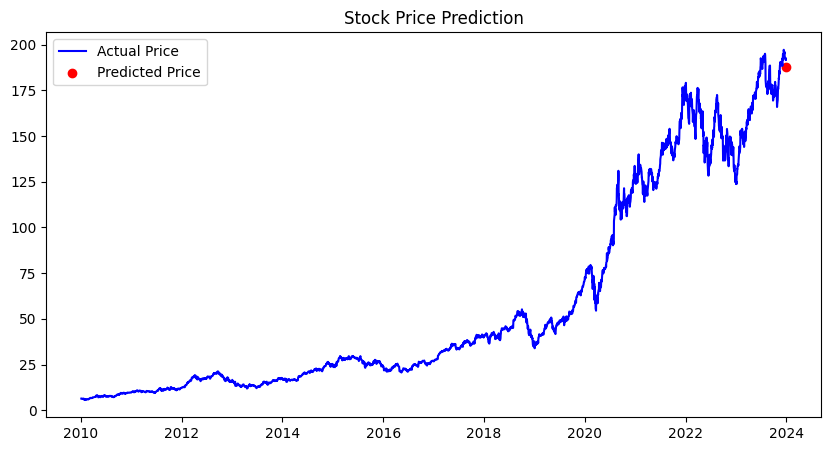

Predicted Closing Price: 187.78387451171875


In [20]:
predict_and_plot(model, df, scaler)

#### Model performance

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

train_loss = model.evaluate(X, y, verbose=1)
y_pred = model.predict(X)

rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Training Loss (MSE): {train_loss:.5f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.5f}")
print(f"R² Score: {r2:.5f} (closer to 1 means better prediction)")


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.7054e-05
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
Training Loss (MSE): 0.00020
Root Mean Squared Error (RMSE): 0.01421
R² Score: 0.99761 (closer to 1 means better prediction)


#### Save the model

In [21]:
import joblib

def save_model(model, scaler, stock_symbol):
    model.save(f"{stock_symbol}_lstm_model.h5")
    joblib.dump(scaler, f"{stock_symbol}_scaler.pkl")
save_model(model, scaler, ticker)